<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_21_DeepLabV3_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 21: Semantic Segmentation с DeepLabV3+


## 📌 Часть 1: Semantic Segmentation с DeepLabV3+

Сегментация изображения — это задача классификации **каждого пикселя** изображения. Semantic Segmentation означает, что всем пикселям, принадлежащим одному классу, присваивается одинаковая метка.



### 📖 Теория: DeepLabV3+

Модель DeepLabV3+ сочетает в себе мощный извлекатель признаков (например, ResNet) с блоком **Atrous Spatial Pyramid Pooling (ASPP)** и **декодером**, который восстанавливает разрешение выходной маски.

#### Архитектура DeepLabV3+
1. **Backbone** (например, ResNet) — извлечение признаков.
2. **ASPP (Atrous Spatial Pyramid Pooling)** — расширенные свёртки для контекста.
3. **Decoder** — восстанавливает маску до исходного разрешения.

#### Почему Atrous Convolution?

Atrous convolution расширяет окно восприятия без увеличения параметров и без уменьшения разрешения признаков:

$$
y[i] = \sum_{k=1}^{K} x[i + r \cdot k] \cdot w[k]
$$

Где:
- \( x \) — входной сигнал,
- \( w \) — веса фильтра,
- \( r \) — параметр дилатации.



### ✅ Преимущества DeepLabV3+
- Улавливает как **локальные**, так и **глобальные** признаки.
- Использует несколько масштабов признаков.
- Хорошо работает с изображениями высокого разрешения.


### 🔧 Практика: Использование модели DeepLabV3+ из torchvision

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


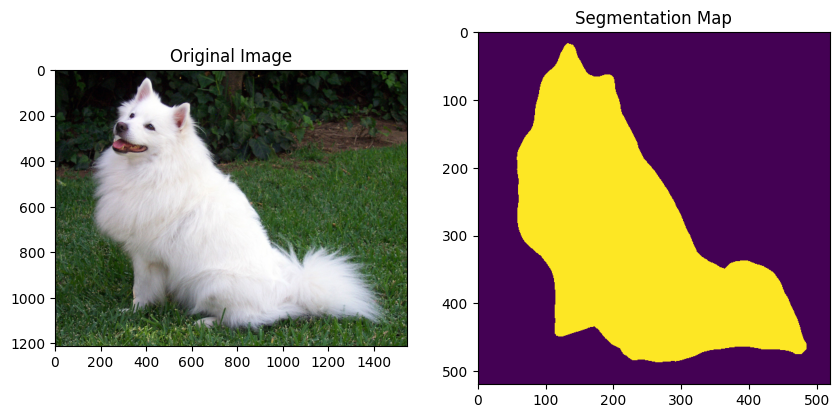

In [3]:

import torchvision
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO


# Загрузка предобученной модели
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Функция предобработки
preprocess = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Загрузка и предобработка изображения
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)

# Прогон через модель
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(output_predictions.numpy())
plt.title("Segmentation Map")
plt.show()


🧠 output = model(input_tensor)['out'][0]
Что происходит:
model(input_tensor) — подаёт изображение в нейросеть DeepLabV3+.

Выход модели — словарь (dict) с ключом 'out':

'out' — это тензор формы (1, C, H, W), где:

C — число классов (например, 21)

H, W — размер изображения

Мы берём output['out'][0], то есть:

[0] убирает первую размерность (батч из 1 изображения)

Получаем output с формой (C, H, W) — это логиты для каждого класса и пикселя

🔢 output_predictions = output.argmax(0)

Что делает argmax(0)?

Мы хотим получить для каждого пикселя — номер класса с наибольшим значением (наиболее вероятный класс).

output имеет форму (C, H, W) → мы берём максимум по оси C:

output_predictions = torch.argmax(output, dim=0)  # (H, W)
Теперь output_predictions содержит матрицу меток классов размера (H, W).

📦 Результат:

output_predictions[i][j] — это ID класса, к которому принадлежит пиксель в позиции (i, j).



## 🧪 Часть 2: OpenCV — семантические маски и overlay


Визуализируем сегментационную маску как цветное изображение и наложим её на оригинальное изображение.

### Алгоритм:
1. Каждому классу присваивается уникальный цвет.
2. Маска преобразуется в цветную с помощью цветовой карты.
3. Используем OpenCV для наложения маски поверх изображения.

### Используемые функции:
- `cv2.applyColorMap()` — для отображения маски.
- `cv2.addWeighted()` — для создания overlay.


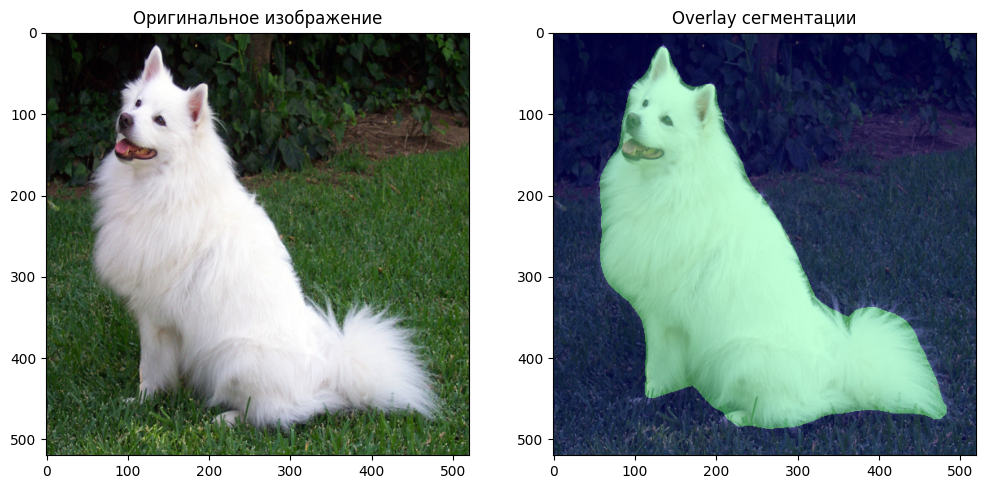

In [5]:

import cv2

# Переводим сегментационную маску в numpy
seg_map = output_predictions.byte().cpu().numpy()

# Масштабируем значения до 0–255 для отображения
seg_color = cv2.applyColorMap((seg_map * 10).astype(np.uint8), cv2.COLORMAP_JET)

# Преобразуем исходное изображение в формат OpenCV
original_img = np.array(img.resize((520, 520)))
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

# Добавляем overlay
overlay = cv2.addWeighted(original_img, 0.6, seg_color, 0.4, 0)

# Отображение
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay сегментации")
plt.show()


📌 seg_map = output_predictions.byte().cpu().numpy()

Что делает:

output_predictions — это тензор (torch.Tensor) с метками классов.

.byte() — преобразует значения к uint8 (целые от 0 до 255).

.cpu() — перемещает тензор из GPU в RAM (если был на CUDA).

.numpy() — переводит в NumPy-массив для совместимости с OpenCV.


📐 В итоге: seg_map — это матрица, где каждый пиксель содержит ID класса.


🎨 seg_color = cv2.applyColorMap((seg_map * 10).astype(np.uint8), cv2.COLORMAP_JET)

Что делает:

Маски обычно имеют значения классов от 0 до ~20, что слишком "тускло".

Умножаем seg_map * 10, чтобы растянуть в диапазон [0, 255].

astype(np.uint8) — приводим тип данных к OpenCV-совместимому.

cv2.applyColorMap(..., cv2.COLORMAP_JET) — применяет цветовую карту JET:

каждый класс отображается разным цветом.


📌 Результат: цветная маска, в которой классы имеют визуально различимые цвета.


🖼️ original_img = np.array(img.resize((520, 520)))

Что делает:

Приводим оригинальное изображение к тому же размеру, что и маска (520x520).

img — это PIL.Image, преобразуем в NumPy-массив (H, W, 3).

🔁 original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
OpenCV ожидает изображения в формате BGR, а не RGB (как у PIL/Matplotlib).

🧃 overlay = cv2.addWeighted(original_img, 0.6, seg_color, 0.4, 0)
Наложение (смешивание) изображения и маски:

result = α * original + β * mask + γ
α = 0.6, β = 0.4, γ = 0 → обычное смешивание.

Позволяет сохранить видимость исходного изображения, подчёркивая зоны сегментации.



## 📐 Часть 3: Линейная алгебра — Метод наименьших квадратов и SVD


В этой части мы рассмотрим, как метод наименьших квадратов (Least Squares) применяется в задачах **оптического потока** — оценки движения между двумя изображениями.

### Проблема:
Для каждого пикселя \( (x, y) \) хотим найти смещение \( (u, v) \), которое удовлетворяет:

$$
I(x + u, y + v, t+1) = I(x, y, t)
$$

Разложим в ряд Тейлора:

$$
I(x + u, y + v, t+1) \approx I(x, y, t) + I_x u + I_y v + I_t
$$

Где:
- \( I_x, I_y \) — градиенты по пространству,
- \( I_t \) — градиент по времени.

Получаем уравнение:

$$
I_x u + I_y v = -I_t
$$

Это **недоопределённая система**, поэтому ищем решение методом наименьших квадратов:

$$
A \cdot
\begin{bmatrix}
u \\
v
\end{bmatrix}
=
b, \quad A =
\begin{bmatrix}
I_x & I_y
\end{bmatrix}, \quad b = -I_t
$$

Минимизируем:

$$
\| A \vec{v} - b \|^2
$$

А решение через SVD или псевдообратную матрицу:

$$
\vec{v} = (A^T A)^{-1} A^T b
$$


### 🔧 Практика: реализация наименьших квадратов через SVD для одного окна

In [6]:

import numpy as np

# Пример градиентов в 3x3 окне
Ix = np.array([1, 1, 1, 0, 0, 0, -1, -1, -1])
Iy = np.array([1, 0, -1, 1, 0, -1, 1, 0, -1])
It = np.array([0.5, 0.4, 0.3, 0.1, 0, -0.1, -0.3, -0.4, -0.5])

A = np.stack([Ix, Iy], axis=1)  # Матрица градиентов
b = -It                        # Правая часть

# Решение через псевдообратную матрицу
v, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

print("Смещение (u, v):", v)


Смещение (u, v): [-0.4 -0.1]


### 🔬 Практика: Оптический поток Лукаса-Канаде на реальных кадрах


Метод Лукаса-Канаде — это локальный подход к оценке оптического потока. Предполагается, что движение в небольшом окне (обычно 5x5 или 15x15) одинаково для всех пикселей, и используется метод наименьших квадратов для оценки смещения.

В OpenCV реализация доступна через:

```python
cv2.calcOpticalFlowPyrLK()
```

Мы используем два последовательных кадра и отслеживаем перемещение точек.


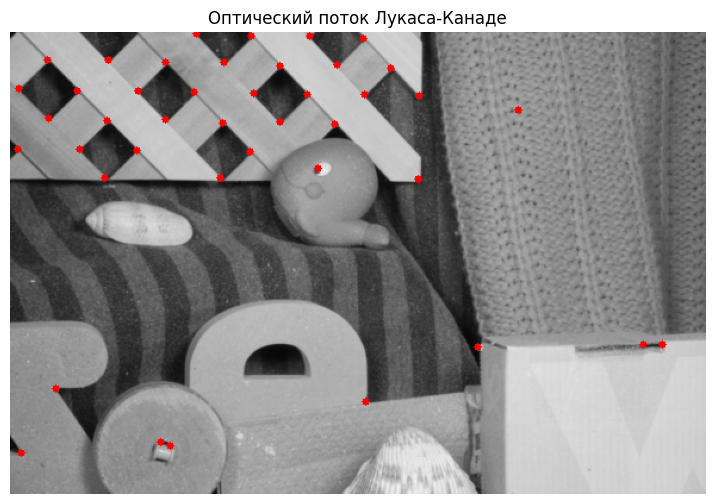

In [8]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка двух последовательных кадров
url1 = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/rubberwhale1.png'
url2 = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/rubberwhale2.png'

def url_to_image(url):
    import urllib.request
    import cv2
    import numpy as np
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    return image

frame1 = url_to_image(url1)
frame2 = url_to_image(url2)

# Инициализация точек для отслеживания
p0 = cv2.goodFeaturesToTrack(frame1, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7)

# Расчет оптического потока
p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None)

# Отображение результата
frame_vis = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)

for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(frame_vis, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(frame_vis, (int(a), int(b)), 3, (0, 0, 255), -1)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
plt.title("Оптический поток Лукаса-Канаде")
plt.axis("off")
plt.show()


🧠 3. Инициализация ключевых точек

p0 = cv2.goodFeaturesToTrack(frame1, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7)
Здесь мы находим углы или важные точки на первом кадре, которые будем отслеживать.

maxCorners=100 — максимум 100 точек

qualityLevel=0.3 — фильтруем только хорошие (высококонтрастные) углы

minDistance=7 — минимальное расстояние между точками

📌 Алгоритм называется Shi-Tomasi Corner Detector.

🎯 4. Расчёт оптического потока

p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None)
Здесь вызывается метод Лукаса-Канаде:

frame1 — исходный кадр

frame2 — следующий кадр

p0 — ключевые точки, которые нужно отслеживать

📌 Результат:

p1 — новые координаты точек в frame2

st — флаг (1/0), успешно ли найдена точка

err — ошибка между предсказанием и реальностью

🎨 5. Визуализация результата

frame_vis = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)
Преобразуем изображение из grayscale в цветное (3 канала), чтобы можно было рисовать цветные линии.

🔁 6. Отрисовка вектора движения

for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(frame_vis, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(frame_vis, (int(a), int(b)), 3, (0, 0, 255), -1)
Для каждой пары (старая точка → новая точка):
рисуем зелёную стрелку (линию) — это направление движения

рисуем красную точку — новое положение

🖼️ 7. Отображение результата

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
plt.title("Оптический поток Лукаса-Канаде")
plt.axis("off")
plt.show()
Конвертируем из BGR → RGB для корректного отображения

Отображаем финальное изображение с векторами движения

💡 В итоге:
Ты получаешь наглядную визуализацию смещений пикселей, рассчитанных через метод наименьших квадратов на окне вокруг каждой ключевой точки.